In [1]:
import certifi
import os
os.environ['SSL-CERT_FILE'] = certifi.where()
from giza_datasets import DatasetsLoader


loader = DatasetsLoader()
df = loader.load("gora-competition-training")
df = df.to_pandas()

Dataset read from cache.
Loading dataset gora-competition-training from cache.


There is an incredible amount of rows in this dataset that are repeated over and over and dont change other than for the metadata time columns 'calc_start_time', 'added_at' , or 'date', becasue of it, you get the same data over and over, this causes a model trained on the whole dataset to heavily overfit to these rows and not generalize well to new data. Excluding these rows from the dataset is a good way to avoid this problem.

In [27]:
import pandas as pd


df = df[df.columns[~pd.Series(df.columns).isin(['calc_start_time', 'added_at' ,'__index_level_0__', 'date'])]]
df.sort_values(by = ['address', 'days_since_first_borrow'], inplace = True, ascending = False)
df.drop_duplicates(subset = df.drop('days_since_first_borrow', axis=1).columns, inplace = True)


<Axes: title={'center': 'Percentage of Loans Liquidated'}, ylabel='proportion'>

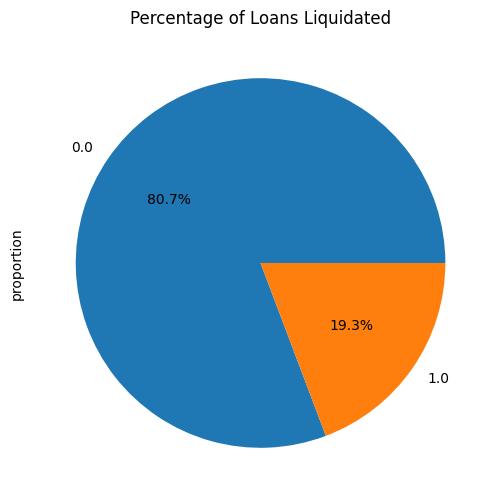

In [79]:
df.liquidated.value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), title='Percentage of Loans Liquidated')	

Even if we can not place each borrow in a sequential time series we do have a valid time feature, first_borrow_date, this tells us how long a certain market participant has been in the borrowing game. Even if not a must for this analyssi, plotting the evolution of the number of new borrowers per day gives an insight into teh DeFi boom and bust cycles from 2019 to 2023

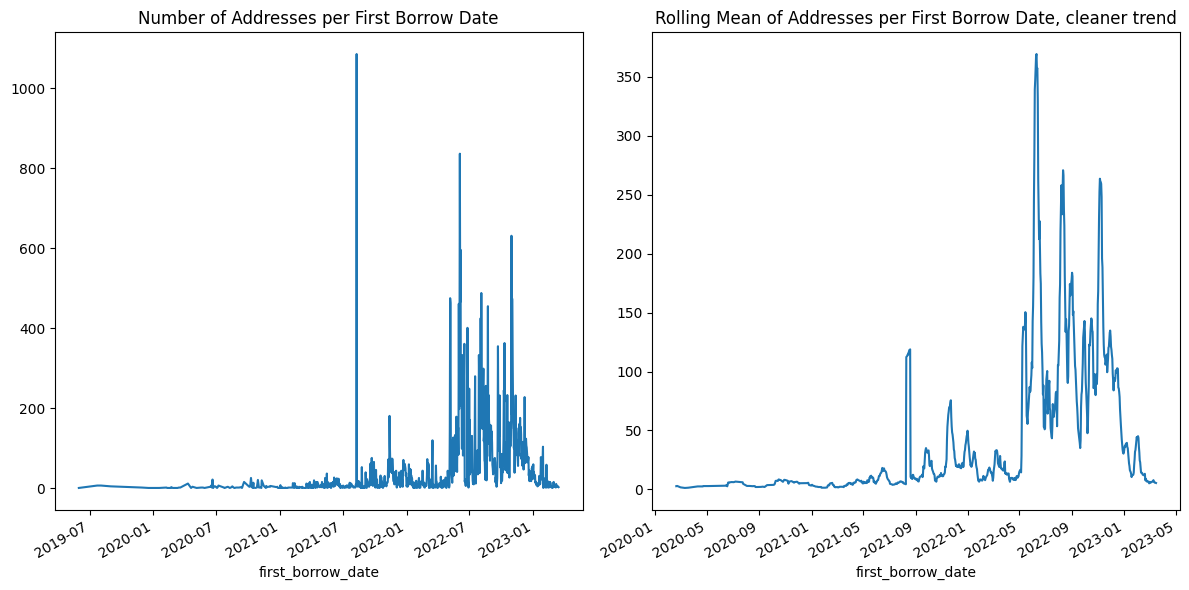

In [41]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot of counts of 'address' for each 'first_borrow_date'
df.set_index('first_borrow_date').groupby('first_borrow_date').count().address.plot(ax=axs[0], title='Number of Addresses per First Borrow Date')

# Plot of rolling mean of counts of 'address' with a window of 10
df.set_index('first_borrow_date').groupby('first_borrow_date').count().address.rolling(window=10).mean().plot(ax=axs[1], title='Rolling Mean of Addresses per First Borrow Date, cleaner trend')

# Enhance layout
plt.tight_layout()
plt.show()

At first I turned all tokens that people borrowed against into lowercase when I saw there were variations in how the case, but turns out there is a huge difference in the mean liquidation between USDC and usdc, thsi must be because they correspond to different protocols.

I saw no improvement in grouping tokens by marketcap or between stablecoins or not or other clusters

In [49]:
df.groupby('token_borrow_mode').liquidated.agg({'mean', 'std', 'count'}).sort_values(by = 'count', ascending=False)

,count,std,mean
token_borrow_mode,,,
USDC,18956,0.381580,0.176883
DAI,13469,0.369281,0.162893
usdc,1751,0.362874,0.844089
GHST,1517,0.166012,0.028345
WMATIC,1082,0.247730,0.065619
WETH,608,0.391946,0.189145
USDT,518,0.356086,0.148649
BUSD,156,0.409715,0.211538
WAVAX,102,0.169792,0.029412


In [42]:
stables = ['usdc', 'dai', 'ghst', 'usdt', 'busd',  'susd',  'dai.e', 'jeur', 'eurs', 'usdc.e', 'usdt.e', 'frax', 'ydai+yusdc+yusdt+ytusd', 'ust',  'yydai+yusdc+yusdt+ytusd']
# Not used, turn out not to be useful.

I am later going to turn all tokens that they used as collateral into a binary dummy variable, so as to not create too many column I group tokens that appeared less that 0.5% of the time into a "other" category

<Axes: title={'center': 'Distribution of the Tokens Borrowed'}, ylabel='proportion'>

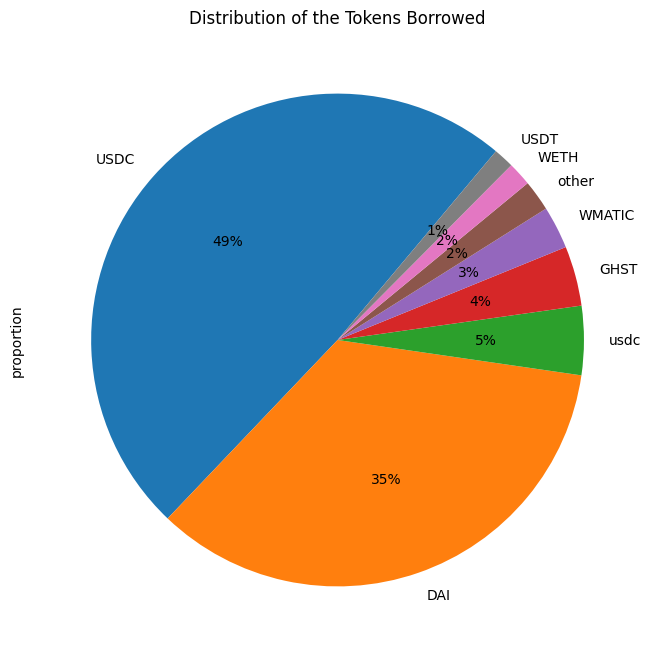

In [70]:
import numpy as np
forbidden =['total_liquidation', 'count_liquidation', 'avg_liquidation_amount', 'std_liquidation_amount', 'liquidation_amount_cv', 'avg_liquidation_to_avg_borrow', 'liquidated']

predictors_df = df[df.columns[~df.columns.isin(forbidden)]].copy()

# predictors_df['stables'] = np.where(predictors_df.token_borrow_mode.isin(stables), 1, 0)
# predictors_df['token_borrow_mode'] = np.where(predictors_df.token_borrow_mode.isin(stables), 'stable', predictors_df.token_borrow_mode)
commonly_borrowed_tokens_tokens = predictors_df.token_borrow_mode.value_counts(normalize=True)[predictors_df.token_borrow_mode.value_counts(normalize=True)*100>0.5].index

predictors_df['token_borrowed'] = np.where(
    predictors_df['token_borrow_mode'].isin(commonly_borrowed_tokens_tokens), 
    predictors_df['token_borrow_mode'], 
    'other'
)

predictors_df.drop('token_borrow_mode', axis=1, inplace=True)
predictors_df.token_borrowed.value_counts(normalize=True).plot(kind='pie', autopct='%1.0f%%', startangle=50, title='Distribution of the Tokens Borrowed', figsize=(8, 8))	

Now that the data contain no unnecesary duplicates, the forbidden columns have been excluded and I have modified the token borrowed feature I will exclude the metadata time columns, turn the token_borrowed into binary columns adn train a LightGBM model on the data to predict the total_liquidation_to_total_borrow ratio, even though this target feature is contained between [0, 1] it is still a regression problem where I am minimizing the RMSE.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8020
[LightGBM] [Info] Number of data points in the train set: 30948, number of used features: 41
[LightGBM] [Info] Start training from score 0.075665
Training RMSE: 0.011613785129458981
Test RMSE: 0.07174779374484332


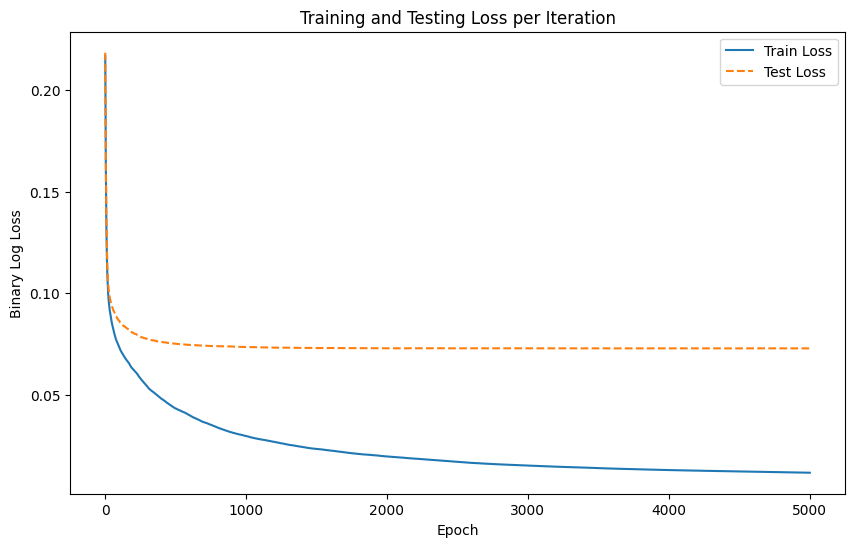

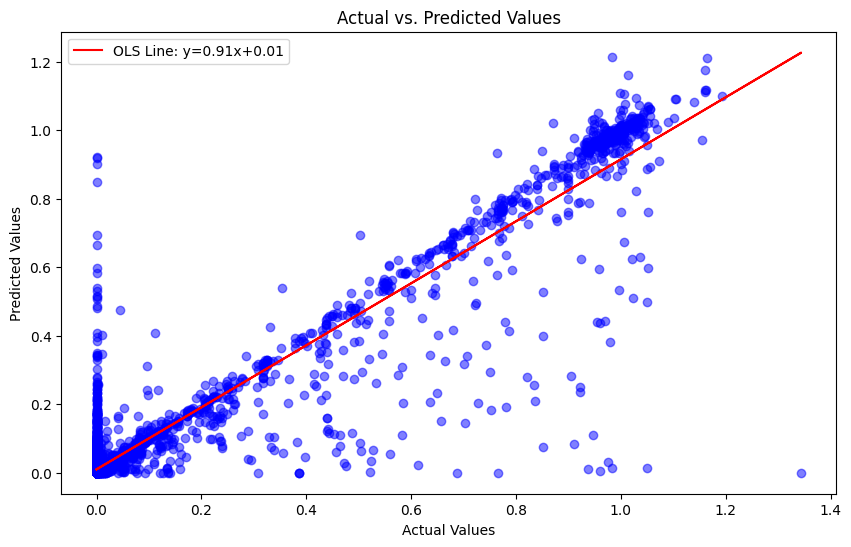

In [71]:
import pandas as pd
predictors_df = predictors_df[['total_borrow', 'count_borrow', 'avg_borrow_amount',
       'std_borrow_amount', 'borrow_amount_cv',
       'total_repay', 'count_repay', 'avg_repay_amount', 'std_repay_amount',
       'repay_amount_cv', 'total_deposit', 'count_deposit',
       'avg_deposit_amount', 'std_deposit_amount', 'deposit_amount_cv',
       'total_redeem', 'count_redeem', 'avg_redeem_amount',
       'std_redeem_amount', 'redeem_amount_cv', 'days_since_first_borrow',
       'net_outstanding', 'int_paid', 'net_deposits',
       'count_repays_to_count_borrows', 'avg_repay_to_avg_borrow',
       'net_outstanding_to_total_borrowed', 'net_outstanding_to_total_repaid',
       'count_redeems_to_count_deposits', 'total_redeemed_to_total_deposits',
       'avg_redeem_to_avg_deposit', 'net_deposits_to_total_deposits',
       'net_deposits_to_total_redeemed', 'dex_total_sum_added',
       'dex_total_sum_removed', 'dex_total_sum_swapped', 'token_borrowed', 'total_liquidation_to_total_borrow']]
# Convert 'token_borrowed' column to dummies
try:
    token_borrowed_dummies = pd.get_dummies(predictors_df['token_borrowed'], prefix='token')
    predictors_df = pd.concat([predictors_df, token_borrowed_dummies], axis=1)
    predictors_df.drop('token_borrowed', axis=1, inplace=True)
except:
    pass
from sklearn.model_selection import train_test_split

# Separate features and target
X = predictors_df.drop('total_liquidation_to_total_borrow', axis=1)
y = predictors_df['total_liquidation_to_total_borrow']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import lightgbm as lgb

# Prepare the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for the LightGBM model
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    
}

# Train the model
evals_result = {}

# Train the model with evaluation results
num_round = 5000
bst = lgb.train(params, train_data, num_round, valid_sets=[train_data, test_data], 
                valid_names=['train', 'test'], callbacks=[
                        #lgb.early_stopping(stopping_rounds=300), 
                        lgb.record_evaluation(evals_result)] )

from sklearn.metrics import log_loss

# Predict probabilities for the training and testing data
y_train_pred = bst.predict(X_train)
y_test_pred = bst.predict(X_test)
y_test_pred = np.maximum(0, y_test_pred) # Given that it is impossbile to have a negative liquidation amount I exclude predictions less than 1

from sklearn.metrics import mean_squared_error

# Calculate the log loss for training and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Extract the log losses for both training and test sets
train_losses = evals_result['train']['rmse']
test_losses = evals_result['test']['rmse']

# Generate the epochs range
epochs = range(1, len(train_losses) + 1)

# Plotting the training and testing loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss', linestyle='--')
plt.title('Training and Testing Loss per Iteration')
plt.xlabel('Epoch')
plt.ylabel('Binary Log Loss')
plt.legend()
plt.show()


X_test_eval = X_test.copy()
X_test_eval['y'] = y_test
y_test_pred = np.maximum(0, y_test_pred)
X_test_eval['y_pred'] = y_test_pred


import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(X_test_eval['y'], X_test_eval['y_pred'], alpha=0.5, color='blue')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Fit and plot OLS regression line
m, b = np.polyfit(X_test_eval['y'], X_test_eval['y_pred'], 1)
plt.plot(X_test_eval['y'], m*X_test_eval['y'] + b, color='red', label=f'OLS Line: y={m:.2f}x+{b:.2f}')

plt.legend()
plt.show()

The scatterplot above shows the actual liquidation percentage over total borrowed on the X axis against the predicted ones by the LightGBM model, looks decently good, there is aclear trend of good predictions, the slope of the line is close to 1 and there is only a 0.01 constant which indicates bias for higer predicted values. We do see a lot of good loans being classified as liquidated tho, these errors are impossbile to avoid but some of the hihger errors are not desirable.

This shows the most important features for this explainable LightGBM model

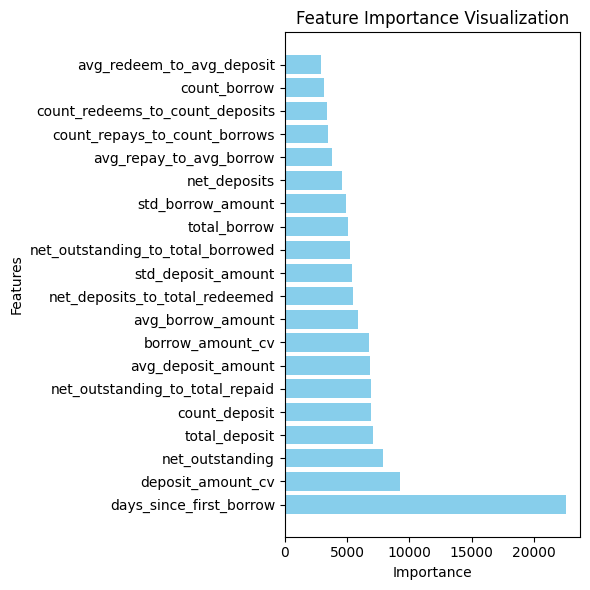

In [74]:
importance = bst.feature_importance()

# Get feature names
feature_names = bst.feature_name()

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature Name': feature_names,
    'Importance': importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_df =feature_importance_df[:20]
# Creating the plot
plt.figure(figsize=(6, 6))
plt.barh(feature_importance_df['Feature Name'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Visualization')
plt.tight_layout()

# Show the plot
plt.show()

To get a better model model, I used autogluon, a auto machine learning module which creates new features out of the data, tries many different models, and combines them to create ensemble predictions based on the output of several of them and using cross validation to not overfit I evaluate if there is one that is better than the LightGBM one. Turns out there is one that is slightly better, even if this is a small differece I chose this model.

In [15]:
from autogluon.tabular import TabularPredictor
from autogluon.features.generators import AutoMLPipelineFeatureGenerator
import pandas as pd
import autogluon.tabular as ag


# Convert 'token_borrowed' column to dummies
try:
    token_borrowed_dummies = pd.get_dummies(predictors_df['token_borrowed'], prefix='token')
    predictors_df = pd.concat([predictors_df, token_borrowed_dummies], axis=1)
    predictors_df.drop('token_borrowed', axis=1, inplace=True)
except Exception as e:
    print(e)

from sklearn.model_selection import train_test_split

# Separate features and target
X = predictors_df.drop('total_liquidation_to_total_borrow', axis=1)
y = predictors_df['total_liquidation_to_total_borrow']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare the training and testing data
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Create the feature generator
feature_generator = AutoMLPipelineFeatureGenerator(
    enable_text_special_features=True,  # Enable special text features
    enable_text_ngram_features=True,    # Enable ngram features from text
    enable_datetime_features=True       # Enable datetime features processing
)

# Initialize the predictor without specifying the feature generator in the constructor
predictor = TabularPredictor(label='total_liquidation_to_total_borrow').fit(
    train_data,
    time_limit=7200,
    num_bag_folds=5,
    num_stack_levels=2,
    feature_generator=feature_generator
)


# Evaluate the model
performance = predictor.evaluate(test_data)

# Print RMSE
print("Test RMSE:", performance['root_mean_squared_error'])



No path specified. Models will be saved in: "AutogluonModels\ag-20240511_215616"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to "AutogluonModels\ag-20240511_215616"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8


Test RMSE: -0.06963340320973253


In [ ]:
import pandas as pd


test = loader.load("gora-competition-real-evaluation.csv")
test = test.to_pandas()

import numpy as np

import certifi
import os

import pandas as pd

test = test[test.columns[~pd.Series(test.columns).isin(['calc_start_time', 'added_at' ,'__index_level_0__', 'date'])]]
test.sort_values(by = ['days_since_first_borrow'], inplace = True, ascending = False)

forbidden =['total_liquidation', 'count_liquidation', 'avg_liquidation_amount', 'std_liquidation_amount', 'liquidation_amount_cv', 'avg_liquidation_to_avg_borrow', 'liquidated']

# forbidden =['total_liquidation', 'count_liquidation', 'avg_liquidation_amount', 'std_liquidation_amount', 'liquidation_amount_cv', 'avg_liquidation_to_avg_borrow']
test = test[test.columns[~test.columns.isin(forbidden)]]

# test['stables'] = np.where(test.token_borrow_mode.isin(stables), 1, 0)
# test['token_borrow_mode'] = np.where(test.token_borrow_mode.isin(stables), 'stable', test.token_borrow_mode)
commonly_borrowed_tokens_tokens = test.token_borrow_mode.value_counts(normalize=True)[test.token_borrow_mode.value_counts(normalize=True)*100>0.1].index

test['token_borrowed'] = np.where(test.token_borrow_mode.isin(commonly_borrowed_tokens_tokens), test.token_borrow_mode, 'other')

test.drop('token_borrow_mode', axis=1, inplace=True)
test.token_borrowed.value_counts(normalize=True)

import pandas as pd
test = test[['total_borrow', 'count_borrow', 'avg_borrow_amount',
       'std_borrow_amount', 'borrow_amount_cv',
       'total_repay', 'count_repay', 'avg_repay_amount', 'std_repay_amount',
       'repay_amount_cv', 'total_deposit', 'count_deposit',
       'avg_deposit_amount', 'std_deposit_amount', 'deposit_amount_cv',
       'total_redeem', 'count_redeem', 'avg_redeem_amount',
       'std_redeem_amount', 'redeem_amount_cv', 'days_since_first_borrow',
       'net_outstanding', 'int_paid', 'net_deposits',
       'count_repays_to_count_borrows', 'avg_repay_to_avg_borrow',
       'net_outstanding_to_total_borrowed', 'net_outstanding_to_total_repaid',
       'count_redeems_to_count_deposits', 'total_redeemed_to_total_deposits',
       'avg_redeem_to_avg_deposit', 'net_deposits_to_total_deposits',
       'net_deposits_to_total_redeemed', 'dex_total_sum_added',
       'dex_total_sum_removed', 'dex_total_sum_swapped', 'token_borrowed']]
# Convert 'token_borrowed' column to dummies
try:
    token_borrowed_dummies = pd.get_dummies(test['token_borrowed'], prefix='token')
    test = pd.concat([test, token_borrowed_dummies], axis=1)
    test.drop('token_borrowed', axis=1, inplace=True)
except:
    pass

test['prediction'] = predictor.predict(test)

test['prediction'] = np.maximum(0, test['prediction']) # Given that it is impossbile to have a negative liquidation amount I exclude predictions less than 1

test.to_csv('test predicted.csv')

I tried using Optuna for finding the best hyperparameters for the LightGBM model, since there was barely any improvement I chose to go with the AutoGluom model instead

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the data
X = predictors_df.drop('total_liquidation_to_total_borrow', axis=1)
y = predictors_df['total_liquidation_to_total_borrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for optimization
def objective(trial):
    # Suggest hyperparameters
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    # Create datasets for LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # Model training
    model = lgb.train(param, train_data, valid_sets=[val_data], num_boost_round=5000)
    
    # Predictions and evaluation
    preds = model.predict(X_test)
    preds = np.maximum(0, preds)  # ensure predictions are non-negative
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    return rmse

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# You can retrieve the best model parameters like this
best_params = study.best_trial.params
print(best_params)


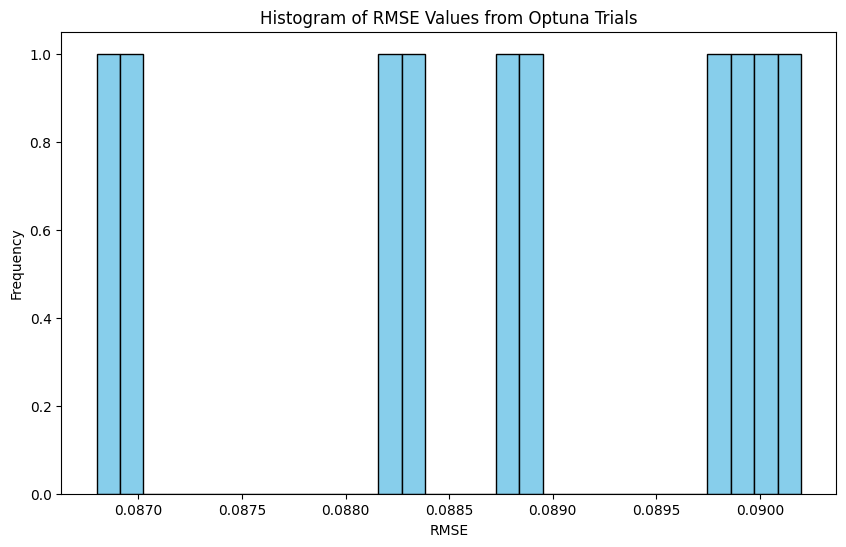

In [15]:
import matplotlib.pyplot as plt

# Extract RMSE values from each trial
rmse_values = [trial.value for trial in study.trials if trial.value is not None]

# Plotting the histogram of RMSE values
plt.figure(figsize=(10, 6))
plt.hist(rmse_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of RMSE Values from Optuna Trials')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.show()
